# Task-3

To design a OpenQASM3 interpreter which does the following:
1. Convert the OpenQASM3 code to a Quantum Circuit
2. Calculates the inverse of the circuit

For this task, I first start with writing out a basic tokenizer and line-by-line interpreter. The code for the tokenizer and interpreter is in the `qasm_to_qiskit_circuit_converter.py` file in the root folder. Then I use this Jupyter notebook to run and analyse a few code samples for OpenQASM3.

In [1]:
# Import the converter class from `qasm_to_qiskit_circuit_converter` file
from qasm_to_qiskit_circuit_converter import QasmToQuantumCircuitConverter

The next step is to write an OpenQASM3 code which defines a random quantum circuit which can be consumed by the converter to generate a Qiskit QuantumCircuit object. Below is a sample OpenQASM3 code.

In [2]:
# Define the QASM input
qasm_input_string = '''

OPENQASM 3.0;
include "stdgates.inc";

qubit[3] q1, q2;
bit[3] c1, c2;

const theta = pi/2;
float lambda = pi/4;

x q1[0];
rz(theta) q1[1];
ry(lambda) q2[2];
h q2[1];
cx q1[1], q2[2];
sdg q1[2];
swap q1[1], q2[2];
ctrl @ swap q1[2], q1[0], q2[1];
barrier q1;

measure q1 -> c1;
barrier q2;

reset q2;
U(0, theta, 0) q2[2];
ctrl @ U(2*lambda, 3*theta/2, pi/2) q1[2], q2[1];
inv @ U(0, 2*theta, 0) q1[0];

c2 = measure q2;

'''.strip()

The above code has the following features:
1. Uses `qubit[.]` and `bit[.]` keywords instead of the old (OpenQASM2) `qreg` and `creg` keywords.
2. Has ability to define variables for parameterized quantum gates (eg: `theta` and `lambda`)
3. Uses gate modifiers like `ctrl` and `inv` which are a new addition to OpenQASM3.
4. Uses two different syntax for `measure` instruction as defined in the old (OpenQASM2) and the new (OpenQASM3) languages.
5. Implements conversion for all the specified gates in the problem, plus a few exttras ;)

These features are crucial to differentiate between OpenQASM3 and OpenQASM2 standards. This is achieved by having the ability to storre the context of the program using a Python dictionary (being used as a Hash-Map here), to store the quantum and classical register objects as well as the variables that are defined during the lifetime of the program.

## Initializing the `QasmToQuantumCircuitConverter`

Below is an example of initializing the converter class with the OpenQASM3 code as an input. The `to_qiskit_circuit()` method is used to convert the OpenQASM3 code into a Qiskit QuantumCircuit object.

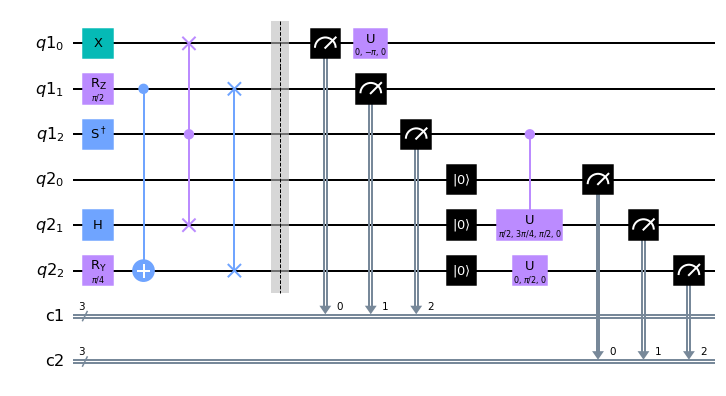

In [3]:
converter = QasmToQuantumCircuitConverter(qasm_input_string)
qc = converter.to_qiskit_circuit()
qc.draw('mpl')

However, the above circuit is not reversible as there are certain non-unitary operations which are a part of it. These non-unitary operations include the `measure` and `reset` instructions. Hence to make this circuit unitary and reversible, we can remove these operations and define a new OpenQASM3 code.

## Making the quantum code unitary and reversible

Below is an OpenQASM3 code which is both unitary and reversible.

In [4]:
qasm_input_string = '''

OPENQASM 3.0;
include "stdgates.inc";

qubit[3] q1, q2;
bit[3] c1, c2;

const theta = pi/2;
float lambda = pi/4;

x q1[0];
rz(theta) q1[1];
ry(lambda) q2[2];
h q2[1];
cx q1[1], q2[2];
sdg q1[2];
swap q1[1], q2[2];
ctrl @ swap q1[2], q1[0], q2[1];
barrier q1;

U(0, theta, 0) q2[2];
ctrl @ U(2*lambda, 3*theta/2, pi/2) q1[2], q2[1];
inv @ U(0, 2*theta, 0) q1[0];

'''.strip()

Following the same approach, we can convert the code into a Qiskit QuantumCircuit object as follows,

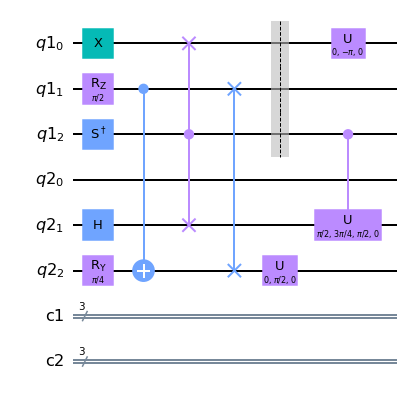

In [5]:
converter2 = QasmToQuantumCircuitConverter(qasm_input_string)
qc = converter2.to_qiskit_circuit()
qc.draw('mpl')

As we can observe, the converter generates correct QuantumCircuit object and draws the circuit properly.

Now, to invert this circuit, we'll make use of the following property of unitary operations. If we have a unitary operation $U$ which is of the form,

$$
U = U_1 \cdot U_2 \cdot U_3 \cdot \dots \cdot U_{m-1} \cdot U_m
$$

We can write the inverse of $U$ i.e. $U^\dagger$ by reversing the orger of operations and taking inverse of each individual $U_i$. This can be represented mathematically as,

$$
U^\dagger = U^\dagger _m \cdot U^\dagger _{m-1} \cdot \dots \cdot U^\dagger _3 \cdot U^\dagger _2 \cdot U^\dagger _1
$$

The code written for the method `to_inverse_qiskit_circuit()` follows a similar approach. First I traverse through the code and store all the quantum and classical registers in the program context (the Python dictionary) and then traverse in the opposite direction to achieve the following:-

1. Reverse the direction of individual unitary operations.
2. Invert each individual unitary operation to get $U^\dagger _i$.

## Inverting the circuit and converting to `QuantumCircuit` object

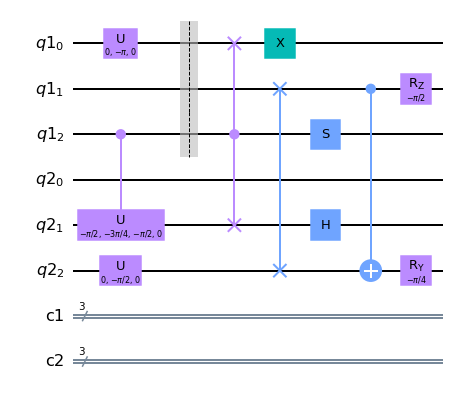

In [6]:
converter3 = QasmToQuantumCircuitConverter(qasm_input_string)
qc = converter3.to_inverse_qiskit_circuit()
qc.draw('mpl')

## Sample for the program context storage
Below is the output for how the converter stores the quantum and classical registers, and variables for the program context. This is very useful as it makes look-up very efficient as Python dictionary is implemented as Hash-Map.

In [7]:
converter.get_variables()

{'q1': QuantumRegister(3, 'q1'),
 'q2': QuantumRegister(3, 'q2'),
 'c1': ClassicalRegister(3, 'c1'),
 'c2': ClassicalRegister(3, 'c2'),
 'theta': ('const', 'pi/2'),
 'lambda': ('float', 'pi/4')}

## Final words
There are many more language features that haven't been shown in this implementation due to the paucity of time for developing this interpreter. These features include:
1. Control flow statements (if-else, for-loop, while-loop, etc)
2. Timing and delay statements
3. `defcal` and `defcalgrammar` that is used for hardware-specific calibration

These features are very complex and needs a full compiler design, which is a very interesting project in itself. Many companies are working on this including IBM, AWS, Honeywell, University of Innsbruck, and many more to develop OpenQASM3 as a open standard for expressing quantum programs. This area has a lot of scope for research and is definitely very interesting!